# Bitcoin prediction with Hierarchical Temporal Memory ML by Numenta
Based on and modified from an example in their core repo:

https://github.com/htm-community/htm.core/blob/master/py/htm/examples/hotgym.py

License will be the same - GNU Affero:

https://github.com/htm-community/htm.core/blob/master/LICENSE.txt

In [1]:
import csv
import datetime
import os
import numpy as np
import random
import math

import matplotlib as mpl
import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style()

#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.dpi'] = 150
plt.rcParams["figure.figsize"] = (11,8)

from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood #FIXME use TM.anomaly instead, but it gives worse results than the py.AnomalyLikelihood now
from htm.bindings.algorithms import Predictor

_EXAMPLE_DIR = os.path.abspath('')
_INPUT_FILE_PATH = os.path.join(_EXAMPLE_DIR, "bitcoin_all.csv")

# copied from https://github.com/htm-community/htm.core/blob/master/py/htm/examples/hotgym.py and modified
# i guess license will be the same

parameters = {
  # there are 2 (3) encoders: "value" (RDSE) & "time" (DateTime weekend, timeOfDay)
 'enc': {
      "value" :
         {'resolution': 0.88, 'size': 800, 'sparsity': 0.02},
      "time": 
         {'timeOfDay': (30, 1), 'weekend': 21}
 },
 'predictor': {'sdrc_alpha': 0.1},
 'sp': {'boostStrength': 3.0,
        'columnCount': 238,
        'localAreaDensity': 0.06395604395604396,
        'potentialPct': 0.95,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'synPermInactiveDec': 0.06},
 'tm': {'activationThreshold': 17,
        'cellsPerColumn': 20,
        'initialPerm': 0.11,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'minThreshold': 10,
        'newSynapseCount': 128,
        'permanenceDec': 0.1,
        'permanenceInc': 0.1},
 'anomaly': {
   'likelihood': 
       {#'learningPeriod': int(math.floor(self.probationaryPeriod / 2.0)),
        #'probationaryPeriod': self.probationaryPeriod-default_parameters["anomaly"]["likelihood"]["learningPeriod"],
        'probationaryPct': 0.1,
        'reestimationPeriod': 100} #These settings are copied from NAB
 }
}


Parameters:
{   'anomaly': {   'likelihood': {   'probationaryPct': 0.1,
                                     'reestimationPeriod': 100}},
    'enc': {   'time': {'timeOfDay': (30, 1), 'weekend': 21},
               'value': {'resolution': 0.88, 'size': 800, 'sparsity': 0.02}},
    'predictor': {'sdrc_alpha': 0.1},
    'sp': {   'boostStrength': 3.0,
              'columnCount': 238,
              'localAreaDensity': 0.06395604395604396,
              'potentialPct': 0.95,
              'synPermActiveInc': 0.04,
              'synPermConnected': 0.13999999999999999,
              'synPermInactiveDec': 0.06},
    'tm': {   'activationThreshold': 17,
              'cellsPerColumn': 20,
              'initialPerm': 0.11,
              'maxSegmentsPerCell': 128,
              'maxSynapsesPerSegment': 64,
              'minThreshold': 10,
              'newSynapseCount': 128,
              'permanenceDec': 0.1,
              'permanenceInc': 0.1}}



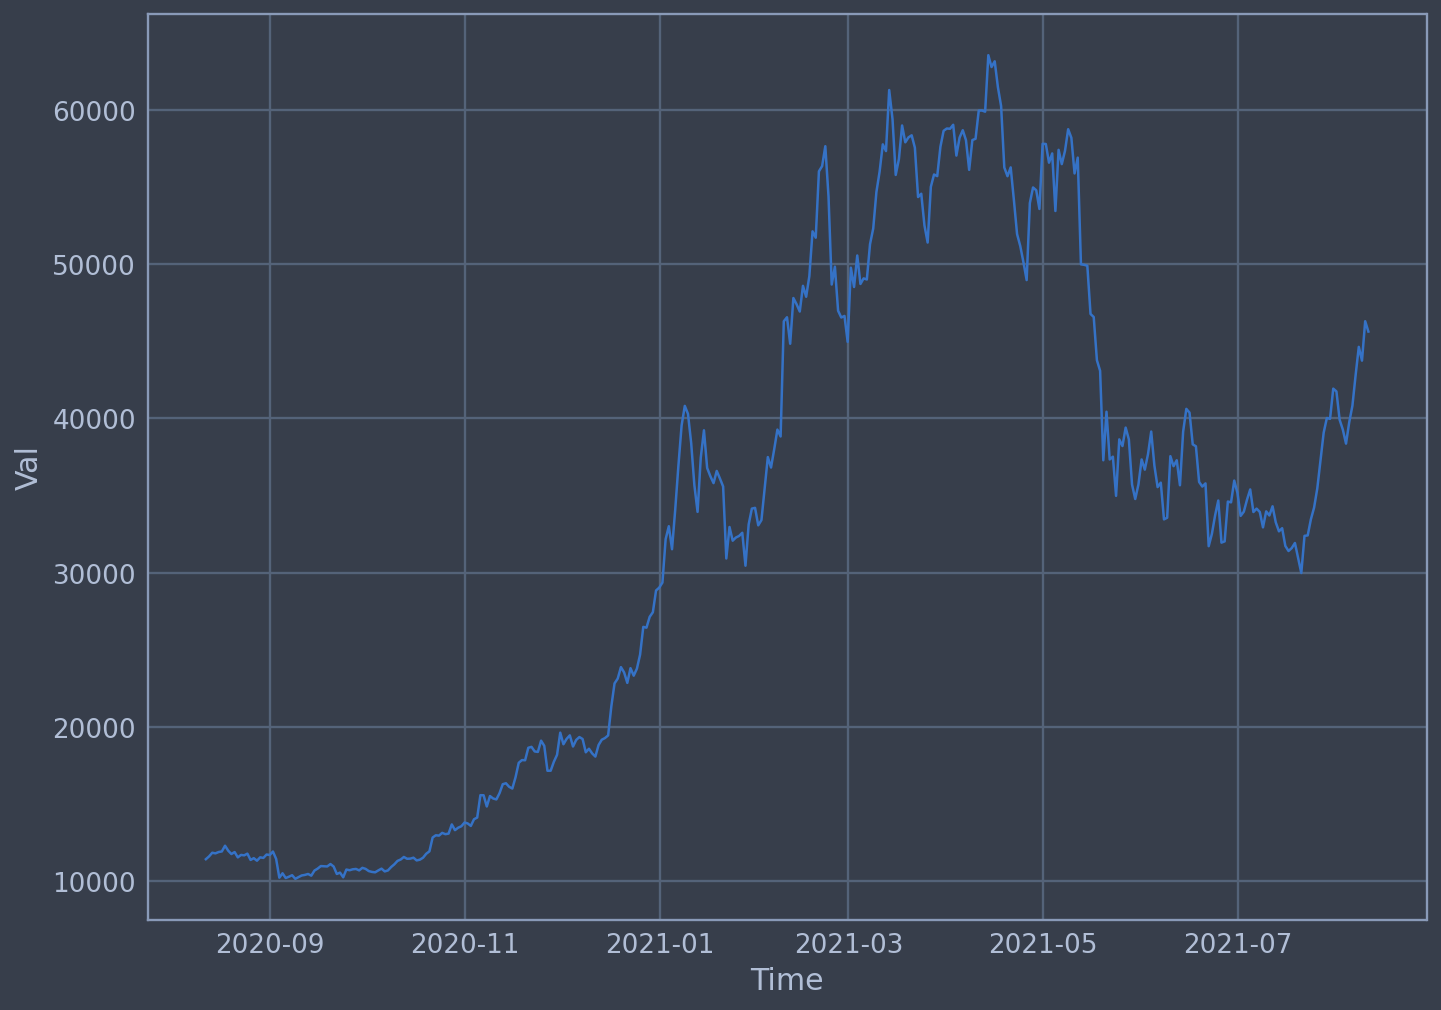

In [2]:
import pprint
print("Parameters:")
pprint.pprint(parameters, indent=4)
print("")

# Read the input file.
records = []
with open(_INPUT_FILE_PATH, "r") as fin:
  reader = csv.reader(fin)
  headers = next(reader)
  for record in reader:
    records.append(record)

x_g = []
y_g = []
for r in records:
    x_g.append(datetime.datetime.strptime(r[0], "%Y-%m-%d %H:%M:%S"))
    y_g.append(float(r[1]))
plt.xlabel("Time")
plt.ylabel("Val")
plt.plot(x_g, y_g)


In [3]:
print("running....")

# Make the Encoders.  These will convert input data into binary representations.
dateEncoder = DateEncoder(timeOfDay= parameters["enc"]["time"]["timeOfDay"], 
                          weekend  = parameters["enc"]["time"]["weekend"]) 

scalarEncoderParams            = RDSE_Parameters()
scalarEncoderParams.size       = parameters["enc"]["value"]["size"]
scalarEncoderParams.sparsity   = parameters["enc"]["value"]["sparsity"]
scalarEncoderParams.resolution = parameters["enc"]["value"]["resolution"]
scalarEncoder = RDSE( scalarEncoderParams )
encodingWidth = (dateEncoder.size + scalarEncoder.size)
enc_info = Metrics( [encodingWidth], 999999999 )

# Make the HTM.  SpatialPooler & TemporalMemory & associated tools.
spParams = parameters["sp"]
sp = SpatialPooler(
  inputDimensions            = (encodingWidth,),
  columnDimensions           = (spParams["columnCount"],),
  potentialPct               = spParams["potentialPct"],
  potentialRadius            = encodingWidth,
  globalInhibition           = True,
  localAreaDensity           = spParams["localAreaDensity"],
  synPermInactiveDec         = spParams["synPermInactiveDec"],
  synPermActiveInc           = spParams["synPermActiveInc"],
  synPermConnected           = spParams["synPermConnected"],
  boostStrength              = spParams["boostStrength"],
  wrapAround                 = True
)
sp_info = Metrics( sp.getColumnDimensions(), 999999999 )

tmParams = parameters["tm"]
tm = TemporalMemory(
  columnDimensions          = (spParams["columnCount"],),
  cellsPerColumn            = tmParams["cellsPerColumn"],
  activationThreshold       = tmParams["activationThreshold"],
  initialPermanence         = tmParams["initialPerm"],
  connectedPermanence       = spParams["synPermConnected"],
  minThreshold              = tmParams["minThreshold"],
  maxNewSynapseCount        = tmParams["newSynapseCount"],
  permanenceIncrement       = tmParams["permanenceInc"],
  permanenceDecrement       = tmParams["permanenceDec"],
  predictedSegmentDecrement = 0.0,
  maxSegmentsPerCell        = tmParams["maxSegmentsPerCell"],
  maxSynapsesPerSegment     = tmParams["maxSynapsesPerSegment"]
)
tm_info = Metrics( [tm.numberOfCells()], 999999999 )

# setup likelihood, these settings are used in NAB
anParams = parameters["anomaly"]["likelihood"]
probationaryPeriod = int(math.floor(float(anParams["probationaryPct"])*len(records)))
learningPeriod     = int(math.floor(probationaryPeriod / 2.0))
anomaly_history = AnomalyLikelihood(learningPeriod= learningPeriod,
                                    estimationSamples= probationaryPeriod - learningPeriod,
                                    reestimationPeriod= anParams["reestimationPeriod"])

predictor = Predictor( steps=[1, 90], alpha=parameters["predictor"]['sdrc_alpha'] )

# Resolution is how accurate the prediction should be to some dollar amount
# resolution 1000 means the prediction will only be accurate within 1000
# That is fine for bitcoin, but the graph will be broken if it is something like dogecoin,
# which is worth under 1 cent
# Predictor resolution needs to match data scale, or else it will take a long time to process.

#Should be based on data fluctuation range I think
resolutions_choices = {
    10: [10000, 999999999999], # max between 10000 - ∞
    1: [1000, 10000],
    0.1: [100, 1000],
    0.01: [0, 10]
}
predictor_resolution = 10
for res in resolutions_choices:
    price_range = resolutions_choices[res]
    if max(y_g) >= price_range[0] and max(y_g) <= price_range[1]:
        predictor_resolution = res

print("predictor_resolution")
print(predictor_resolution)

# Iterate through every datum in the dataset, record the inputs & outputs.
inputs      = []
anomaly     = []
anomalyProb = []
predictions = {1: [], 90: []}
for count, record in enumerate(records):

  # Convert date string into Python date object.
  dateString = datetime.datetime.strptime(record[0], "%Y-%m-%d %H:%M:%S")
  # Convert data value string into float.
  consumption = float(record[1])
  inputs.append( consumption )

  # Call the encoders to create bit representations for each value.  These are SDR objects.
  dateBits        = dateEncoder.encode(dateString)
  consumptionBits = scalarEncoder.encode(consumption)

  # Concatenate all these encodings into one large encoding for Spatial Pooling.
  encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
  enc_info.addData( encoding )

  # Create an SDR to represent active columns, This will be populated by the
  # compute method below. It must have the same dimensions as the Spatial Pooler.
  activeColumns = SDR( sp.getColumnDimensions() )

  # Execute Spatial Pooling algorithm over input space.
  sp.compute(encoding, True, activeColumns)
  sp_info.addData( activeColumns )

  # Execute Temporal Memory algorithm over active mini-columns.
  tm.compute(activeColumns, learn=True)
  tm_info.addData( tm.getActiveCells().flatten() )

  # Predict what will happen, and then train the predictor based on what just happened.
  pdf = predictor.infer( tm.getActiveCells() )
  for n in (1, 90):
    if pdf[n]:
      predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
    else:
      predictions[n].append(float('nan'))

  anomalyLikelihood = anomaly_history.anomalyProbability( consumption, tm.anomaly )
  anomaly.append( tm.anomaly )
  anomalyProb.append( anomalyLikelihood )

  predictor.learn(count, tm.getActiveCells(), int(consumption / predictor_resolution))


# Print information & statistics about the state of the HTM.
print("Encoded Input", enc_info)
print("")
print("Spatial Pooler Mini-Columns", sp_info)
print(str(sp))
print("")
print("Temporal Memory Cells", tm_info)
print(str(tm))
print("")

# Shift the predictions so that they are aligned with the input they predict.
for n_steps, pred_list in predictions.items():
  for x in range(n_steps):
      pred_list.insert(0, float('nan'))
      pred_list.pop()

# Calculate the predictive accuracy, Root-Mean-Squared
accuracy         = {1: 0, 90: 0}
accuracy_samples = {1: 0, 90: 0}

for idx, inp in enumerate(inputs):
  for n in predictions: # For each [N]umber of time steps ahead which was predicted.
    val = predictions[n][ idx ]
    if not math.isnan(val):
      accuracy[n] += (inp - val) ** 2
      accuracy_samples[n] += 1
for n in sorted(predictions):
  accuracy[n] = (accuracy[n] / accuracy_samples[n]) ** .5
  print("Predictive Error (RMS)", n, "steps ahead:", accuracy[n])

# Show info about the anomaly (mean & std)
print("Anomaly Mean", np.mean(anomaly))
print("Anomaly Std ", np.std(anomaly))

running....
predictor_resolution
10
Encoded Input SDR( 1562 )
    Sparsity Min/Mean/Std/Max 0.0416133 / 0.0427831 / 0.000259796 / 0.0428937
    Activation Frequency Min/Mean/Std/Max 0 / 0.0427832 / 0.124808 / 0.635617
    Entropy 0.523231
    Overlap Min/Mean/Std/Max 0.313433 / 0.675705 / 0.143599 / 0.850746

Spatial Pooler Mini-Columns SDR( 238 )
    Sparsity Min/Mean/Std/Max 0.0630252 / 0.0630249 / 1.94619e-06 / 0.0630252
    Activation Frequency Min/Mean/Std/Max 0 / 0.0630252 / 0.0222314 / 0.0876712
    Entropy 0.971661
    Overlap Min/Mean/Std/Max 0 / 0.202747 / 0.247093 / 0.933333
Spatial Pooler Connections:
    Inputs (1562) ~> Outputs (238) via Segments (238)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 1484 / 1484 / 1484
    Connected Synapses on Segment Min/Mean/Max 45 / 113.45 / 778
    Synapses Dead (0.874991%) Saturated (0.0256744%)
    Synapses pruned (0%) Segments pruned (0%)
    Buffer for destroyed synapses: 0    Buffer for 

Graph of training progress through the set. Gets more accurated as it gets further through the set:


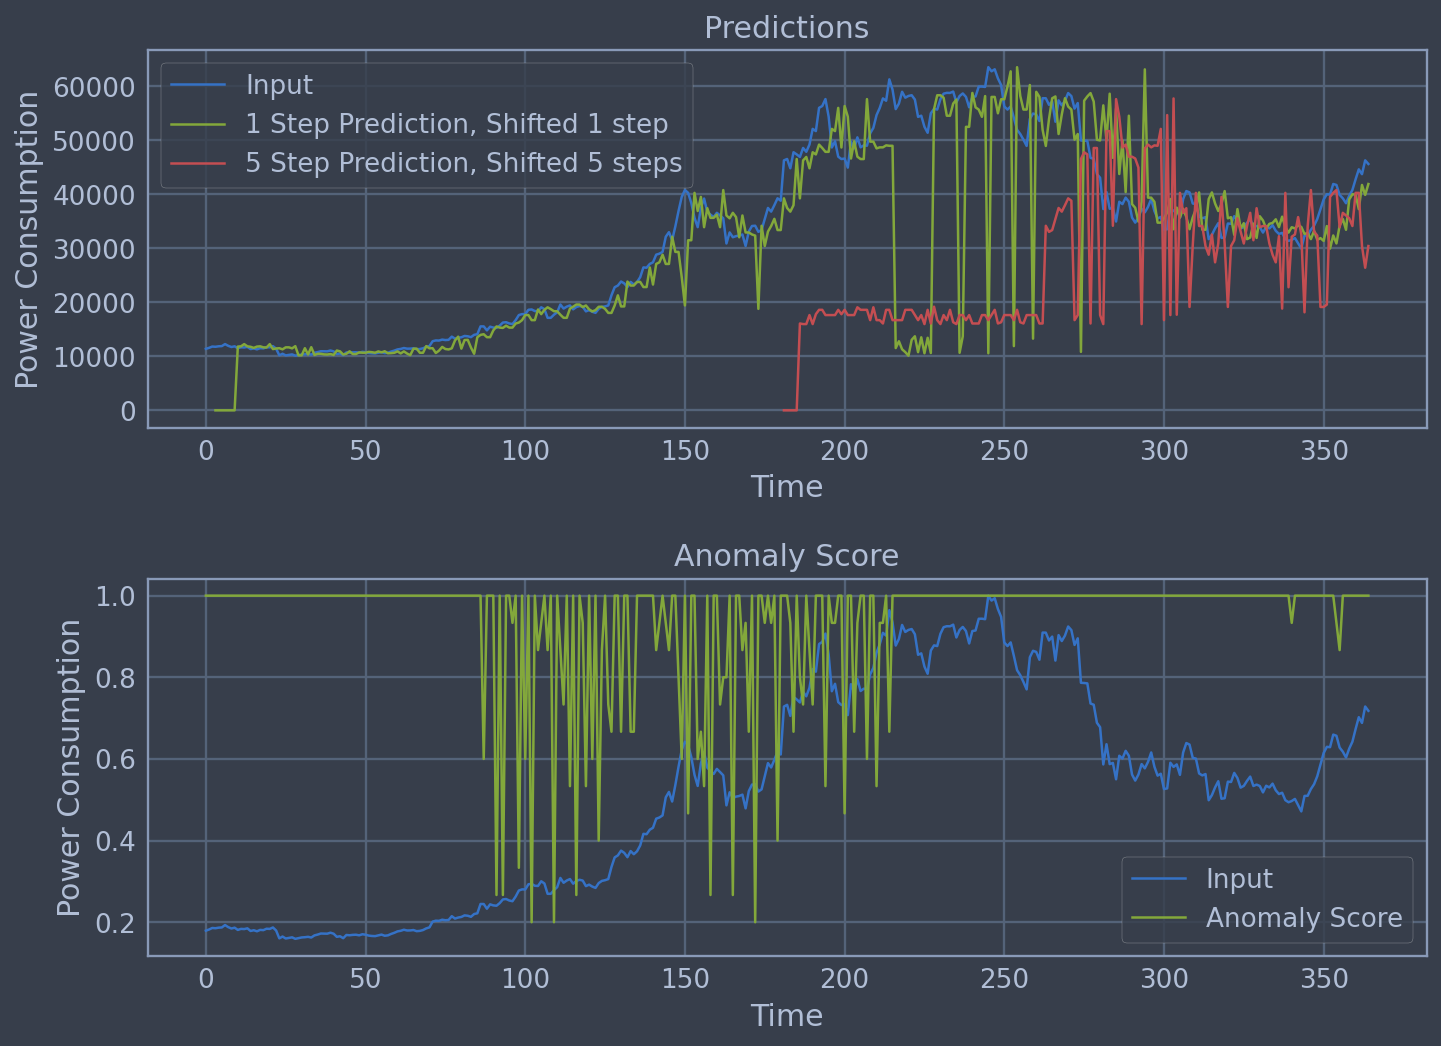

-accuracy[5]: -27450.940582151623


In [4]:
# Plot the Predictions and Anomalies.
print("Graph of training progress through the set. Gets more accurated as it gets further through the set:")

plt.subplot(2,1,1)
plt.title("Predictions")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
plt.plot(np.arange(len(inputs)), y_g,
        np.arange(len(inputs)), predictions[1],
        np.arange(len(inputs)), predictions[90])
plt.legend(labels=('Input', '1 Step Prediction, Shifted 1 step', '5 Step Prediction, Shifted 5 steps'))

plt.subplot(2,1,2)
plt.title("Anomaly Score")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
inputs = np.array(inputs) / max(inputs)
plt.plot(np.arange(len(inputs)), inputs,
        np.arange(len(inputs)), anomaly)
plt.legend(labels=('Input', 'Anomaly Score'))

plt.subplots_adjust(hspace=0.4)
plt.show()

print("-accuracy[5]:", -accuracy[90])

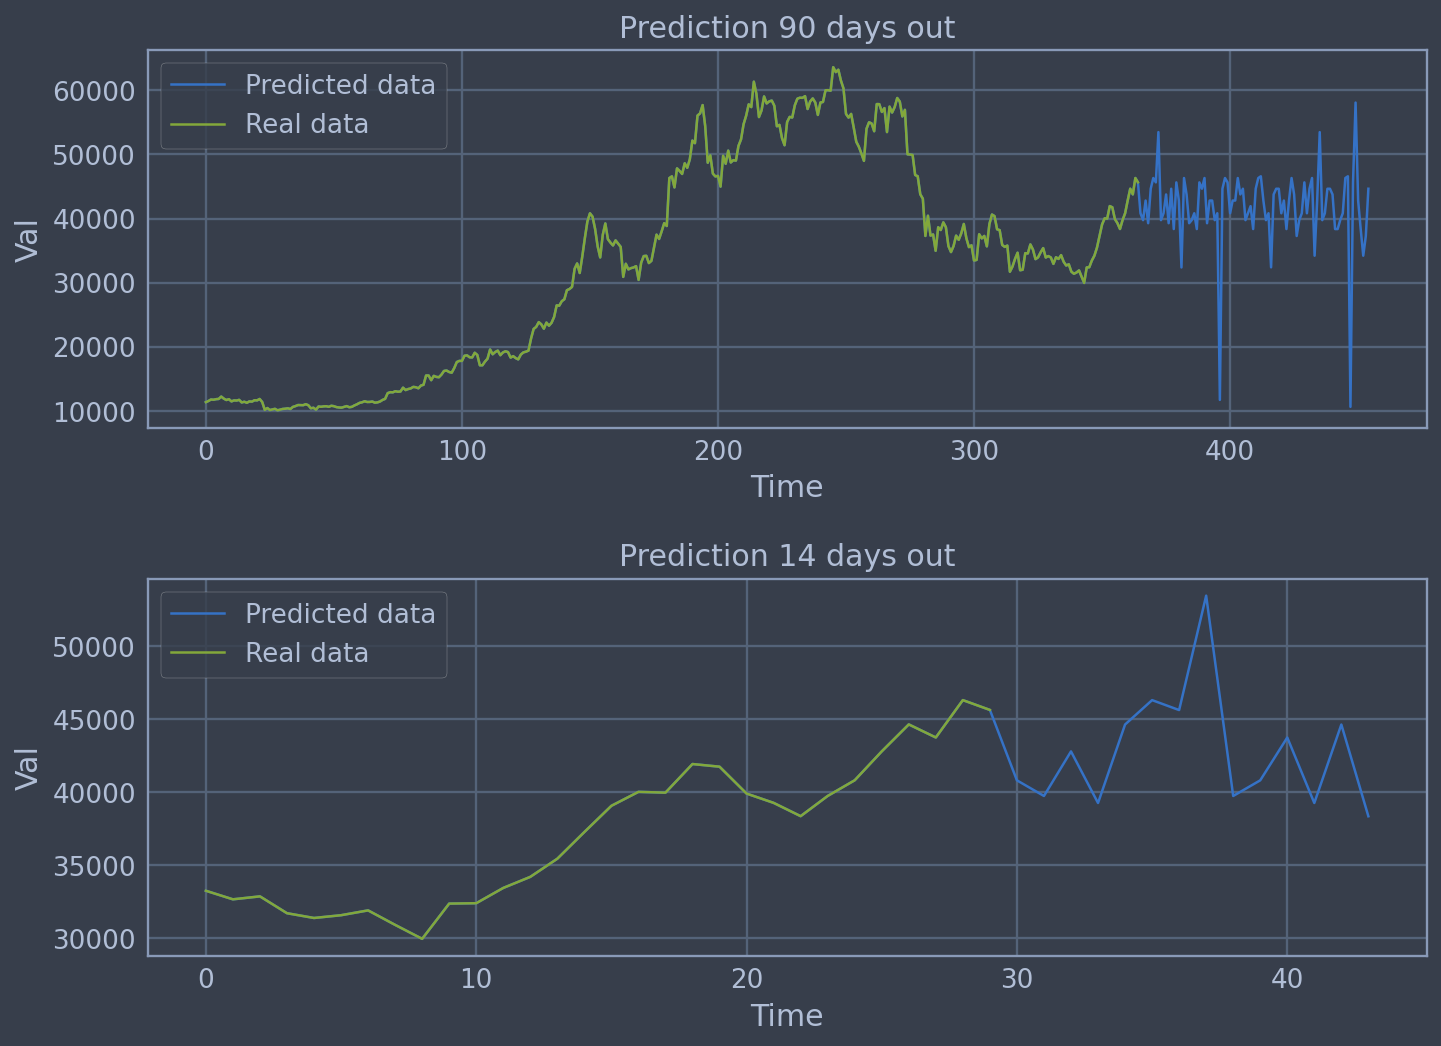

In [5]:


#print(records)
goal_len = len(records) + 90
while len(records) < goal_len:
  record = records[-1]

  # Convert date string into Python date object.
  dateString = datetime.datetime.strptime(record[0], "%Y-%m-%d %H:%M:%S")
  dateStringPlusOne = (datetime.datetime.strptime(record[0], "%Y-%m-%d %H:%M:%S")+datetime.timedelta(days=1))
  dateStringPlusOne = dateStringPlusOne.strftime("%Y-%m-%d %H:%M:%S")
  # Convert data value string into float.
  consumption = float(record[1])
  #inputs.append( consumption )

  # Call the encoders to create bit representations for each value.  These are SDR objects.
  dateBits        = dateEncoder.encode(dateString)
  consumptionBits = scalarEncoder.encode(consumption)

  # Concatenate all these encodings into one large encoding for Spatial Pooling.
  encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
  enc_info.addData( encoding )

  # Create an SDR to represent active columns, This will be populated by the
  # compute method below. It must have the same dimensions as the Spatial Pooler.
  activeColumns = SDR( sp.getColumnDimensions() )

  # Execute Spatial Pooling algorithm over input space.
  sp.compute(encoding, True, activeColumns)
  sp_info.addData( activeColumns )

  # Execute Temporal Memory algorithm over active mini-columns.
  tm.compute(activeColumns, learn=False)
  tm_info.addData( tm.getActiveCells().flatten() )

  # Predict what will happen, and then add to records for next prediction
  pdf = predictor.infer( tm.getActiveCells() )
  #for n in (1):#, 5):
  if pdf[1]:
    #predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
    records.append([dateStringPlusOne, np.argmax( pdf[1] ) * predictor_resolution])
  else:
    records.append([dateStringPlusOne, records[-1][1]])
    #predictions[n].append(float('nan'))

y_g2 = []
for r in records:
    #x_g.append(datetime.datetime.strptime(r[0], "%Y-%m-%d %H:%M:%S"))
    y_g2.append(float(r[1]))

#print(y_)

plt.subplot(2,1,1)
plt.title("Prediction 90 days out")
plt.xlabel("Time")
plt.ylabel("Val")
plt.plot(np.arange(len(y_g2)), y_g2, np.arange(len(y_g)), y_g)
plt.legend(labels=('Predicted data', 'Real data'))

y_g = y_g[-30:]
y_g2 = y_g2[-120:]
y_g2 = y_g2[0:len(y_g) + 14]

plt.subplot(2,1,2)
plt.title("Prediction 14 days out")
plt.xlabel("Time")
plt.ylabel("Val")
plt.plot(np.arange(len(y_g2)), y_g2, np.arange(len(y_g)), y_g)
plt.legend(labels=('Predicted data', 'Real data'))

plt.subplots_adjust(hspace=0.4)
plt.show()

import sys

csv = "i,ds,y\n"
for i in range(len(records)):
    csv += "_," + ",".join(map(str, records[i]))
    csv += "\n"

f = open("./predictions-cache/bitcoin.csv", "w")#+sys.argv[1], "w")
f.write(csv)
f.close()

Better than the LSTM neural net's prediction, which just copied exactly what happened the previous 90 days and pasted it at the end of the current graph, as a cheat to get to high accuracy.

This looks a little more believeable as forecasting real data, but a downside of this method I see is that it isn't able to grasp the trend. The forecasted data fluctuates around an average with no upward downward overall trend. This effect isn't as noticeable with smaller timeframes so I will just hide it by not predicting beyond 14 days or so.

Wasn't going for super high accuracy or anything to actually use in a real trading scenario anyway, more of just a fun project/neat feature. Accurately predicting markets is a full time job in and of itself and even then it's still hard/impossible to get it perfect.

Leaving as per day granularity for now as this at least looks passable. Tried to switch it to hourly as in cryptodash-client <90d data is displayed by the hour, but model fell apart. Maybe todo to tweak and get that working eventually but this is fine for now.